In [1]:
import numpy as np
import math
from qpandalite.simulator import Simulator, NoisySimulator
from qpandalite.qasm_origin import OpenQASM2_Parser
from qpandalite.circuit_builder import Circuit

In [2]:
Pauli_I = np.array([[1, 0], [0, 1]])
Pauli_X = np.array([[0, 1], [1, 0]])
Pauli_Y = np.array([[0, -1j], [1j, 0]])
Pauli_Z = np.array([[1, 0], [0, -1]])

In [3]:
# Probability of noise channel
p_depol = 0.0
p_damp = 0.1
p_bitflip = 0.0
p_phaseflip = 0.0

# Kraus operators for depolarizing
E0_depol = np.sqrt(1 - 3 * p_depol/4) * Pauli_I
E1_depol = np.sqrt(p_depol)/2 * Pauli_X
E2_depol = np.sqrt(p_depol)/2 * Pauli_Y
E3_depol = np.sqrt(p_depol)/2 * Pauli_Z

# Kraus operators for amplitude damping
E0_damp = np.array([[1, 0], [0, np.sqrt(1 - p_damp)]])
E1_damp = np.array([[0, np.sqrt(p_damp)], [0, 0]])

# Kraus operators for bit-flip
E0_bitflip = np.sqrt(1 - p_bitflip/2) * Pauli_I
E1_bitflip = np.sqrt(p_bitflip/2) * Pauli_X

# Kraus operators for phase-flip
E0_phaseflip = np.sqrt(1 - p_phaseflip/2) * Pauli_I
E1_phaseflip = np.sqrt(p_phaseflip/2) * Pauli_Z

In [4]:
# Define the number of qubits
n_qubit = 1

# depth
depth=20

# Noise description
noise_description = {
	"depolarizing": p_depol/np.sqrt(2),  # 5% depolarizing noise
	"damping": p_damp,        # 5% damping noise
	"bitflip": p_bitflip/2,     # 5% bitflip noise
	"phaseflip": p_phaseflip/2  # 5% phaseflip noise
}

# Measurement error matrices (placeholder values)
readout_error = [
	[0.9, 0.1],
	[0.1, 0.9]
]

We will have one experiment to test whether the damping noise working fine.
1. Because each gate will introduce the noise once, each time we apply a pair of x gates, the have probabilty of decay from |1> to |0>

In [5]:
measurement_results = []

for j in range(depth):
    # Create an instance of the NoisySimulator
    simulator = NoisySimulator(n_qubit, noise_description, readout_error)
    
    # Number of measurement shots
    shots = 4096

    # Adding an x-gate will induce the noise channel once
    simulator.x(0)
    
    # Apply j-time noise channel 
    for _ in range(j):
        simulator.insert_error([0])
    # Therefore, each circuit in the for loop will have (j+1) noise channel    
    
    # Measure the state multiple times
    measurement_results.append(simulator.measure_shots(shots))

In [6]:
# Initial density matrix of the qubit in the |1> state
rho_initial = np.array([[0, 0], [0, 1]])

# Projector onto state |1>
P1 = np.array([[0, 0], [0, 1]])

# Number of times the damping noise is applied
n_times = depth

# Store the probabilities of measuring state |0>
probabilities_1 = []

# Apply the damping noise n times and calculate probability after each application
for n in range(1, n_times + 1):
    # Apply the noise
    rho = E0_depol @ rho_initial @ E0_depol.conj().T + E1_depol @ rho_initial @ E1_depol.conj().T + E2_depol @ rho_initial @ E2_depol.conj().T + E3_depol @ rho_initial @ E3_depol.conj().T
    rho = E0_damp @ rho @ E0_damp.conj().T + E1_damp @ rho @ E1_damp.conj().T
    rho = E0_bitflip @ rho @ E0_bitflip.conj().T + E1_bitflip @ rho @ E1_bitflip.conj().T
    rho = E0_phaseflip @ rho @ E0_phaseflip.conj().T + E1_phaseflip @ rho @ E1_phaseflip.conj().T
    # Calculate the probability of measuring state |0>
    probability_1 = np.trace(P1 @ rho)
    probabilities_1.append(probability_1)
    # Update the initial density matrix for the next iteration
    rho_initial = rho
# The list probabilities_1 will contain the density matrix after (i+1) noise channel

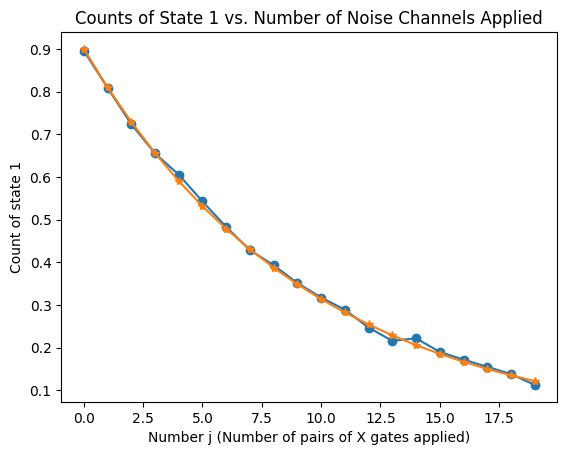

In [7]:
import matplotlib.pyplot as plt

# Assuming measurement_results is a list of dictionaries with state as keys and count as values
state_one_counts = []

# Collect counts for state '1'
for meas_result in measurement_results:
    count = meas_result.get(1, 0)  # Get the count for state '1', defaulting to 0 if not found
    state_one_counts.append(count)

# Now plot these counts against the number j
plt.plot(range(depth), np.array(state_one_counts)/shots, marker='o')
plt.plot(range(depth), np.abs(probabilities_1), marker='*')
plt.xlabel('Number j (Number of pairs of X gates applied)')
plt.ylabel('Count of state 1')
plt.title('Counts of State 1 vs. Number of Noise Channels Applied')
plt.show()
